In [1]:
import pandas as pd
import seaborn as sns
import pandas as pd
import warnings
from matplotlib.lines import Line2D
import numpy as np

warnings.simplefilter(action="ignore", category=Warning)
import numpy as np
from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['pdf.fonttype'] = 42  # Ensures text is stored as editable Type 1 fonts
plt.rcParams['ps.fonttype'] = 42   # For EPS compatibility

meta_info = pd.read_csv("../../data/meta_info_visium.csv")
meta_info[meta_info['organ']=='Lymphoid']['organ'] = 'Lymph node'

method = ['ours', 'gigapath-MLP', 'hoptimus-MLP', 'uni-MLP', 'pca-MLP']
model_names = ['Ours', 'H-Optimus', 'Prov-GigaPath', 'UNI', 'PCA']
model_color = ['#d53e4f', '#ef8a62', '#dd3497', '#998ec3', '#4393c3']
# model_color = ['#b2182b', '#fdae61', '#e6f598', '#762a83', '#878787']

pretrain_organs = ['Spinal cord', 'Brain', 'Breast', 'Bowel', 'Skin']  # top five organs
pretrain_samples = meta_info[meta_info['organ'].isin(pretrain_organs)]['sample'].tolist()
test_samples = meta_info[~meta_info['organ'].isin(pretrain_organs)]['sample'].tolist()
valid_samples = pretrain_samples[-100:]
train_samples = pretrain_samples[:20]
samples = valid_samples + test_samples

print(meta_info[meta_info['sample'].isin(valid_samples)]['organ'].value_counts())

for i, method_m in enumerate(method):
    if method_m == 'ours':
        result_df_m1 = pd.read_csv(f"../../result/{method_m}_visium_organ_out.csv")
    else:
        result_df_m1 = pd.read_csv(f"../../result/{method_m}_visium_organ.csv")
        result_df_m1 = result_df_m1[result_df_m1['sample'].isin(samples)]
    # result_df_m1 = result_df_m1.rename(columns={'group': 'sample'})
    result_df_m1['method'] = [f'{model_names[i]}'] * result_df_m1.shape[0]
    result_df_m1['domain'] = ['top5organ'] * result_df_m1.shape[0]
    result_df_m1['organ'] = [meta_info[meta_info['sample']==s]['organ'].tolist()[0] for s in result_df_m1['sample'].tolist()]
    result_df_m1['species'] = [meta_info[meta_info['sample']==s]['species'].tolist()[0] for s in result_df_m1['sample'].tolist()]
    result_df_m1['tech'] = [meta_info[meta_info['sample']==s]['tech'].tolist()[0] for s in result_df_m1['sample'].tolist()]
    
    result_df_m2 = pd.read_csv(f"../../result/{method_m}_visium_mouse2human.csv")
    result_df_m2 = result_df_m2[result_df_m2['sample'].isin(samples)]
    # result_df_m2 = result_df_m2.rename(columns={'group': 'sample'})
    result_df_m2['method'] = [f'{model_names[i]}'] * result_df_m2.shape[0]
    result_df_m2['domain'] = ['mouse2human'] * result_df_m2.shape[0]
    result_df_m2['organ'] = [meta_info[meta_info['sample']==s]['organ'].tolist()[0] for s in result_df_m2['sample'].tolist()]
    result_df_m2['species'] = [meta_info[meta_info['sample']==s]['species'].tolist()[0] for s in result_df_m2['sample'].tolist()]
    result_df_m2['tech'] = [meta_info[meta_info['sample']==s]['tech'].tolist()[0] for s in result_df_m2['sample'].tolist()]
    
    result_df_m = pd.concat([result_df_m1, result_df_m2], ignore_index=True)
    
    if i == 0:
        result_df = result_df_m
    else:
        result_df = pd.concat([result_df, result_df_m], ignore_index=True)

organ
Spinal cord    36
Brain          30
Skin           12
Breast         12
Bowel          10
Name: count, dtype: int64


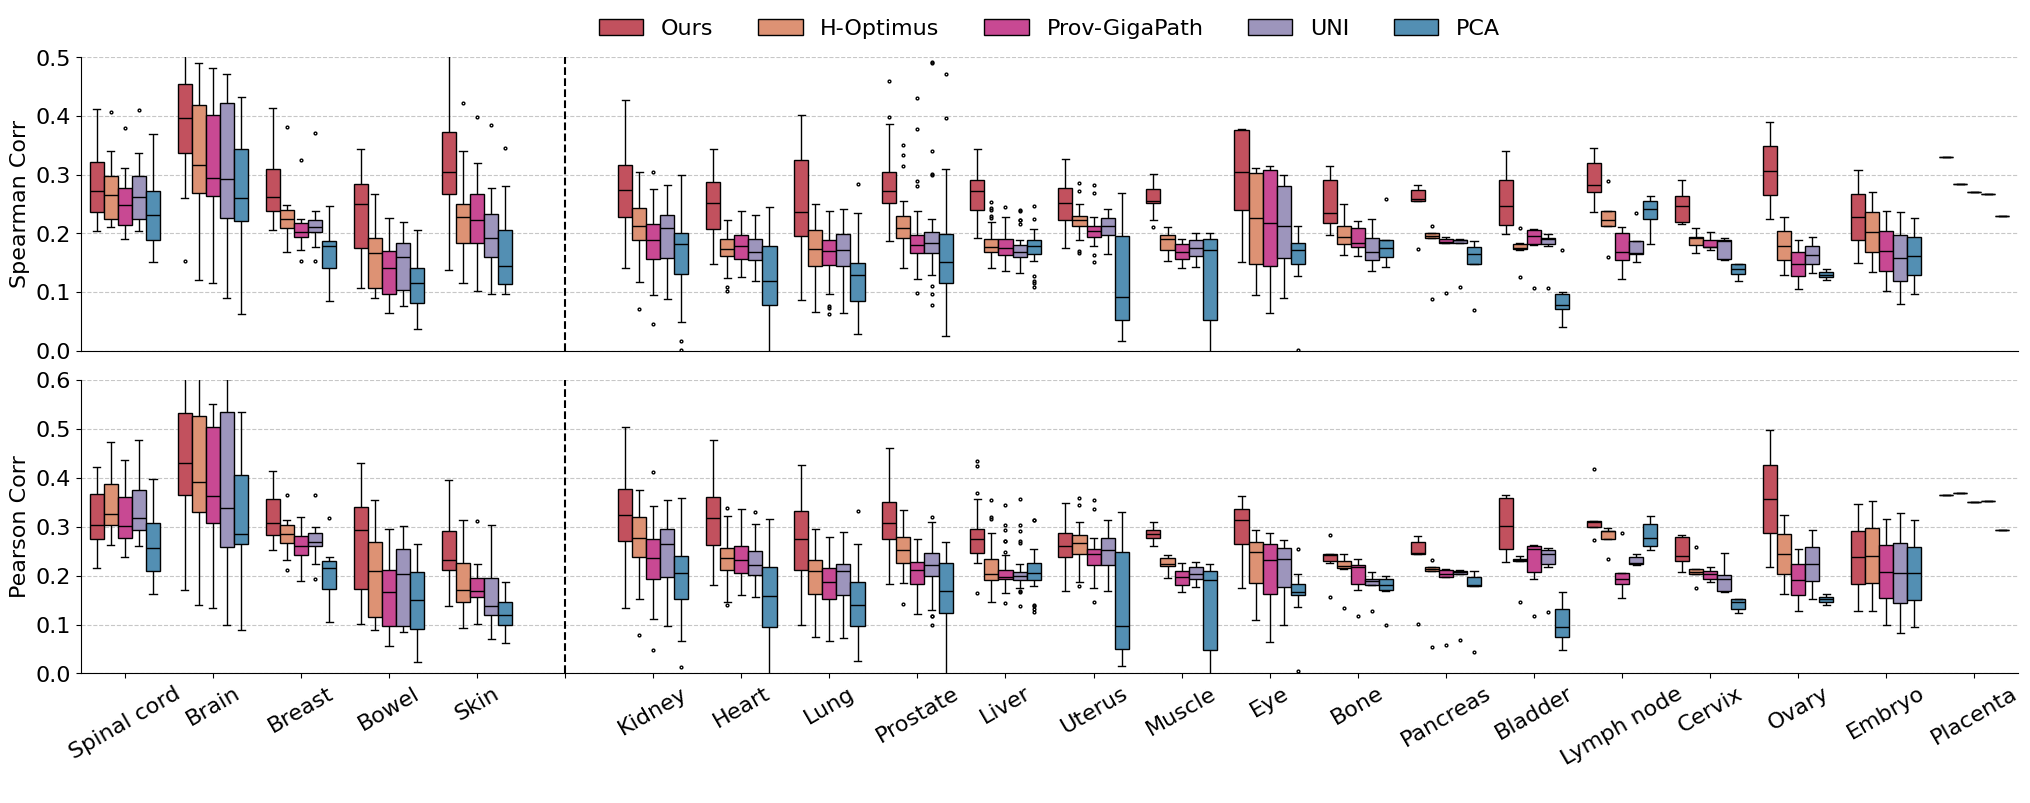

In [2]:
metrics = ['Spearman', 'Pearson']
gene_tops = [4000]

organs = ['Spinal cord', 'Brain', 'Breast', 'Bowel', 'Skin', ' ', 'Kidney', 'Heart', 'Lung', 'Prostate', 'Liver', 'Uterus', 'Muscle', 'Eye', 'Bone', 
          'Pancreas', 'Bladder', 'Lymph node', 'Cervix', 'Ovary', 'Embryo', 'Placenta']

result_df_plot = result_df[result_df['domain']=='top5organ']
# result_df_plot = result_df_plot[result_df_plot['tech']=='Visium']

num_plots = len(metrics) * len(gene_tops)
fig, axes = plt.subplots(num_plots, 1, figsize=(25, 8), sharex=True, gridspec_kw={'hspace': 0.1})
axes = axes.flatten()

for m, metric in enumerate(metrics):
    for g, gene_top in enumerate(gene_tops):
        ax = axes[m*len(gene_tops)+g]
        score_key = f'{metric} of top {gene_top} genes'
        sns.boxplot(x='organ', y=score_key, hue='method', data=result_df_plot, palette=model_color, linecolor='black', 
                    linewidth=1.0, fliersize=2.0, ax=ax, order=organs)
        ax.set_xlabel(' ', fontsize=14)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_xticklabels(organs, rotation=30) 
        ax.axvline(x=5, color='black', linestyle='--', linewidth=1.5)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-axis
axes[0].set_ylim(0, 0.5)
axes[0].set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5]) 
axes[1].set_ylim(0, 0.6) 
axes[1].set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) 
axes[0].legend(loc='upper center', fontsize=16, ncols=5, bbox_to_anchor=(0.5, 1.2), frameon=False)
axes[1].get_legend().remove()
axes[0].set_ylabel(f'Spearman Corr', fontsize=16)
axes[1].set_ylabel(f'Pearson Corr', fontsize=16)

# axes[1].text(3, -0.25, 'in training data', ha='center', va='top', fontsize=16)
# axes[1].text(10, -0.25, 'out of training data', ha='center', va='top', fontsize=16)

plt.tight_layout()
plt.show()

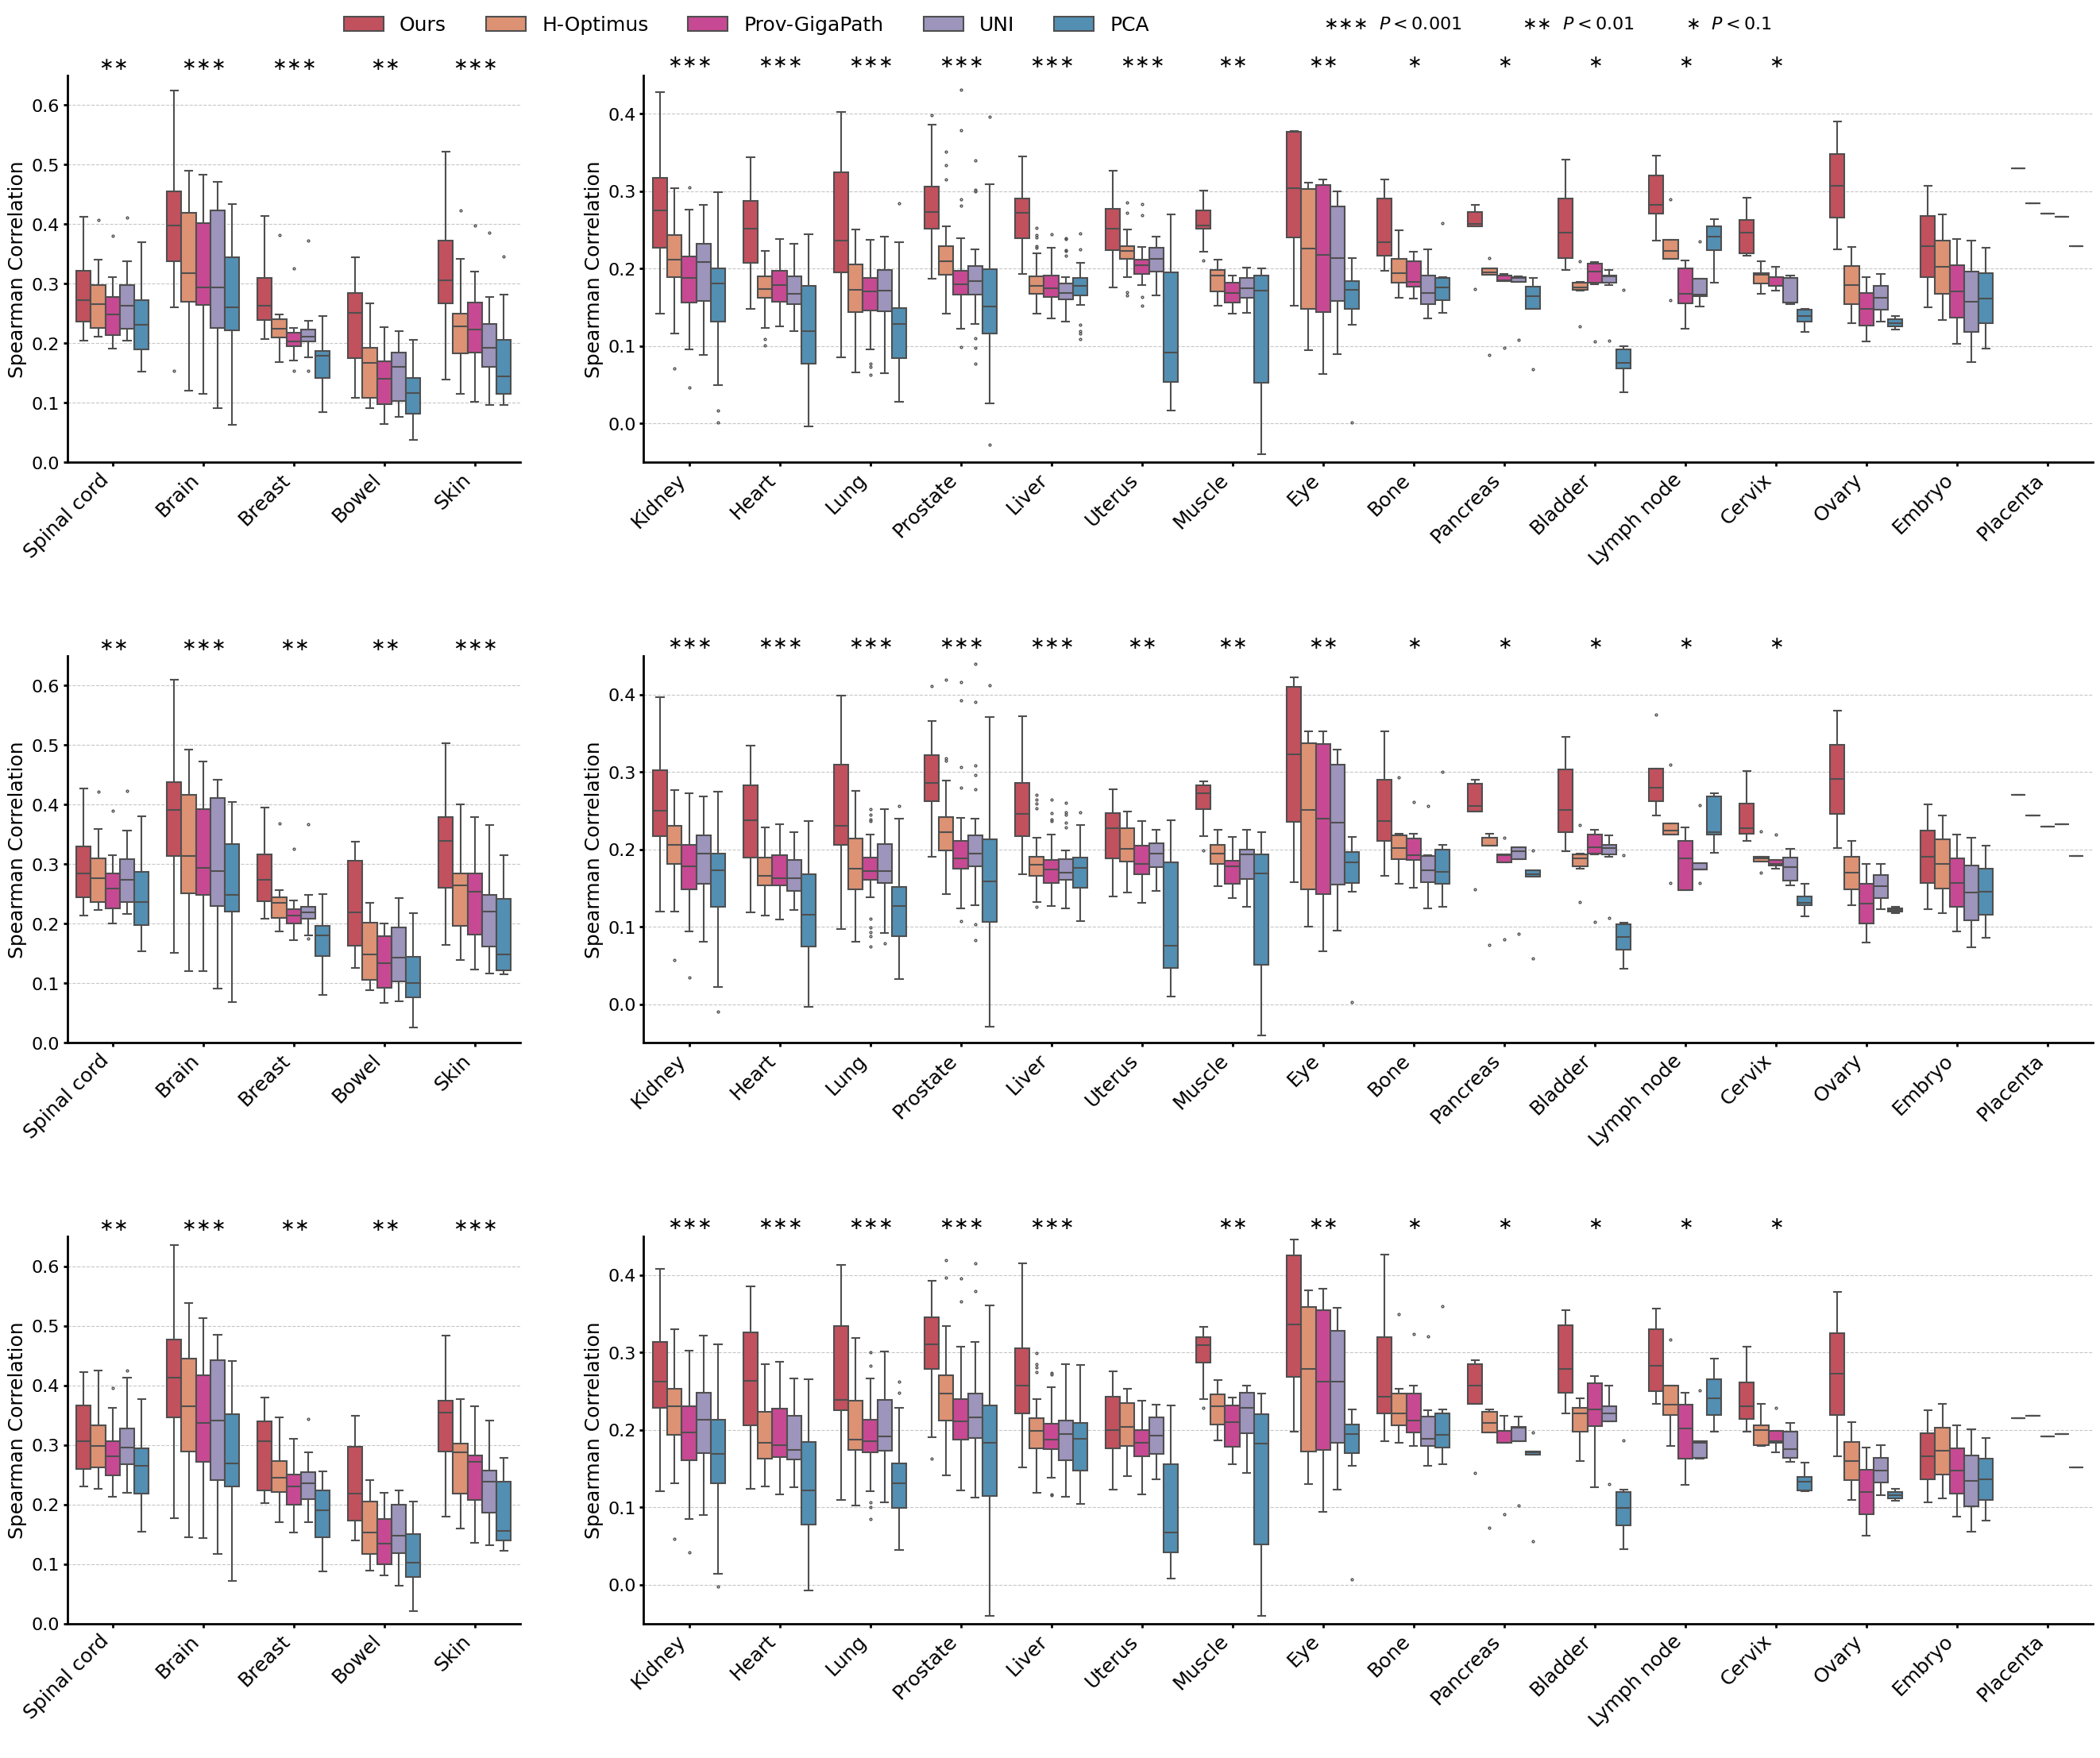

In [3]:
from scipy.stats import wilcoxon

metrics = ['Spearman']
gene_tops = [4000, 2000, 1000]

organs = ['Spinal cord', 'Brain', 'Breast', 'Bowel', 'Skin', ' ', 'Kidney', 'Heart', 'Lung', 'Prostate', 'Liver', 'Uterus', 'Muscle', 'Eye', 'Bone', 
          'Pancreas', 'Bladder', 'Lymph node', 'Cervix', 'Ovary', 'Embryo', 'Placenta']
organs1 = organs[:5]
organs2 = organs[6:]

significance_symbol = [r'$\ast$$\ast$$\ast$', r'$\ast$$\ast$', r'$\ast$', ' ']

result_df_plot = result_df[result_df['domain']=='top5organ']
# result_df_plot = result_df_plot[result_df_plot['tech']=='Visium']
result_df_plot1 = result_df_plot[result_df_plot['organ'].isin(organs1)]
result_df_plot2 = result_df_plot[result_df_plot['organ'].isin(organs2)]


fig, axes = plt.subplots(3, 2, figsize=(30, 30), gridspec_kw={'hspace': 0.5, 'wspace': 0.13, 'width_ratios': [len(organs1), len(organs2)]})
axes = axes.flatten()

for i in range(len(gene_tops)):
    ax = axes[2*i]
    score_key = f'Spearman of top {gene_tops[i]} genes'
    result_df_plot2[score_key][result_df_plot2[score_key] < -0.04] = -0.04
    
    sns.boxplot(x='organ', y=score_key, hue='method', data=result_df_plot1, palette=model_color, 
                linewidth=1.5, fliersize=2.0, width=0.8, ax=ax, order=organs1)
    ax.set_xlabel(' ', fontsize=14)
    ax.tick_params(axis='x', labelsize=18, width=2)
    ax.tick_params(axis='y', labelsize=18, width=2)
    ax.set_ylim(0, 0.65)
    ax.set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) 
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel(r'Spearman Correlation', fontsize=18)
    ax.set_xticklabels(organs1, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    
    x_loc1 = [-0.25, 0.75, 1.75, 2.75, 3.75]
    significance_label1 = [1, 0, 0, 1, 0]
    for x_loc, organ in zip(x_loc1, organs1):
        result_df_o = result_df_plot1[result_df_plot1['organ']==organ]
        p_values, baselines = [], []
        for m in model_names:
            score_m = result_df_o[result_df_o['method']==m][score_key].to_numpy()
            if m == 'Ours':
                score_m_ours = score_m
            else:
                _, p_value = wilcoxon(score_m_ours, score_m)
                p_values += [p_value]
                baselines += [np.mean(score_m)]
        p_value = p_values[np.argmax(baselines)]
        sig_label = 0 if p_value < 0.001 else 1 if p_value < 0.01 else 2 if p_value < 0.1 else 3
        ax.text(x_loc+0.25, 0.66, significance_symbol[sig_label], horizontalalignment='center', fontsize=16)
    ax.get_legend().remove()

    ax = axes[2*i+1]
    sns.boxplot(x='organ', y=score_key, hue='method', data=result_df_plot2, palette=model_color, 
                linewidth=1.5, fliersize=2.0, width=0.8, ax=ax, order=organs2)
    ax.set_xlabel(' ', fontsize=14)
    ax.tick_params(axis='x', labelsize=18, width=2)
    ax.tick_params(axis='y', labelsize=18, width=2)
    ax.set_ylim(-0.05, 0.45) 
    ax.set_yticks([0., 0.1, 0.2, 0.3, 0.4]) 
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel(r'Spearman Correlation', fontsize=18)
    ax.set_xticklabels(organs2, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    
    x_loc2 = [-0.25, 0.75, 1.75, 2.75, 3.75, 4.75, 5.75, 6.75, 7.75, 8.75, 9.75, 10.75, 11.75, 12.75, 13.75, 14.75]
    significance_label2 = [0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2 ,3, 3, 3]
    for x_loc, organ in zip(x_loc2, organs2):
        result_df_o = result_df_plot2[result_df_plot2['organ']==organ]
        score_ours = result_df_o[result_df_o['method']=='Ours'][score_key].tolist()
        score_comp_best = result_df_o[result_df_o['method']=='H-Optimus'][score_key].tolist()
        stat, p_value = wilcoxon(score_ours, score_comp_best)
        sig_label = 0 if p_value < 0.001 else 1 if p_value < 0.01 else 2 if p_value < 0.1 else 3
        ax.text(x_loc+0.25, 0.46, significance_symbol[sig_label], horizontalalignment='center', fontsize=16)
    ax.get_legend().remove()
    # axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-axis
    

axes[0].legend(loc='upper center', fontsize=18, ncols=5, bbox_to_anchor=(1.5, 1.2), frameon=False)
axes[1].text(7, 0.51, r'$\ast$$\ast$$\ast$  $P<0.001$', fontsize=16)
axes[1].text(9.2, 0.51, r'$\ast$$\ast$  $P<0.01$', fontsize=16)
axes[1].text(11, 0.51, r'$\ast$  $P<0.1$', fontsize=16)


# plt.tight_layout()
fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.25)

plt.savefig('../../figure/pred_visium_organ.pdf')
plt.show()

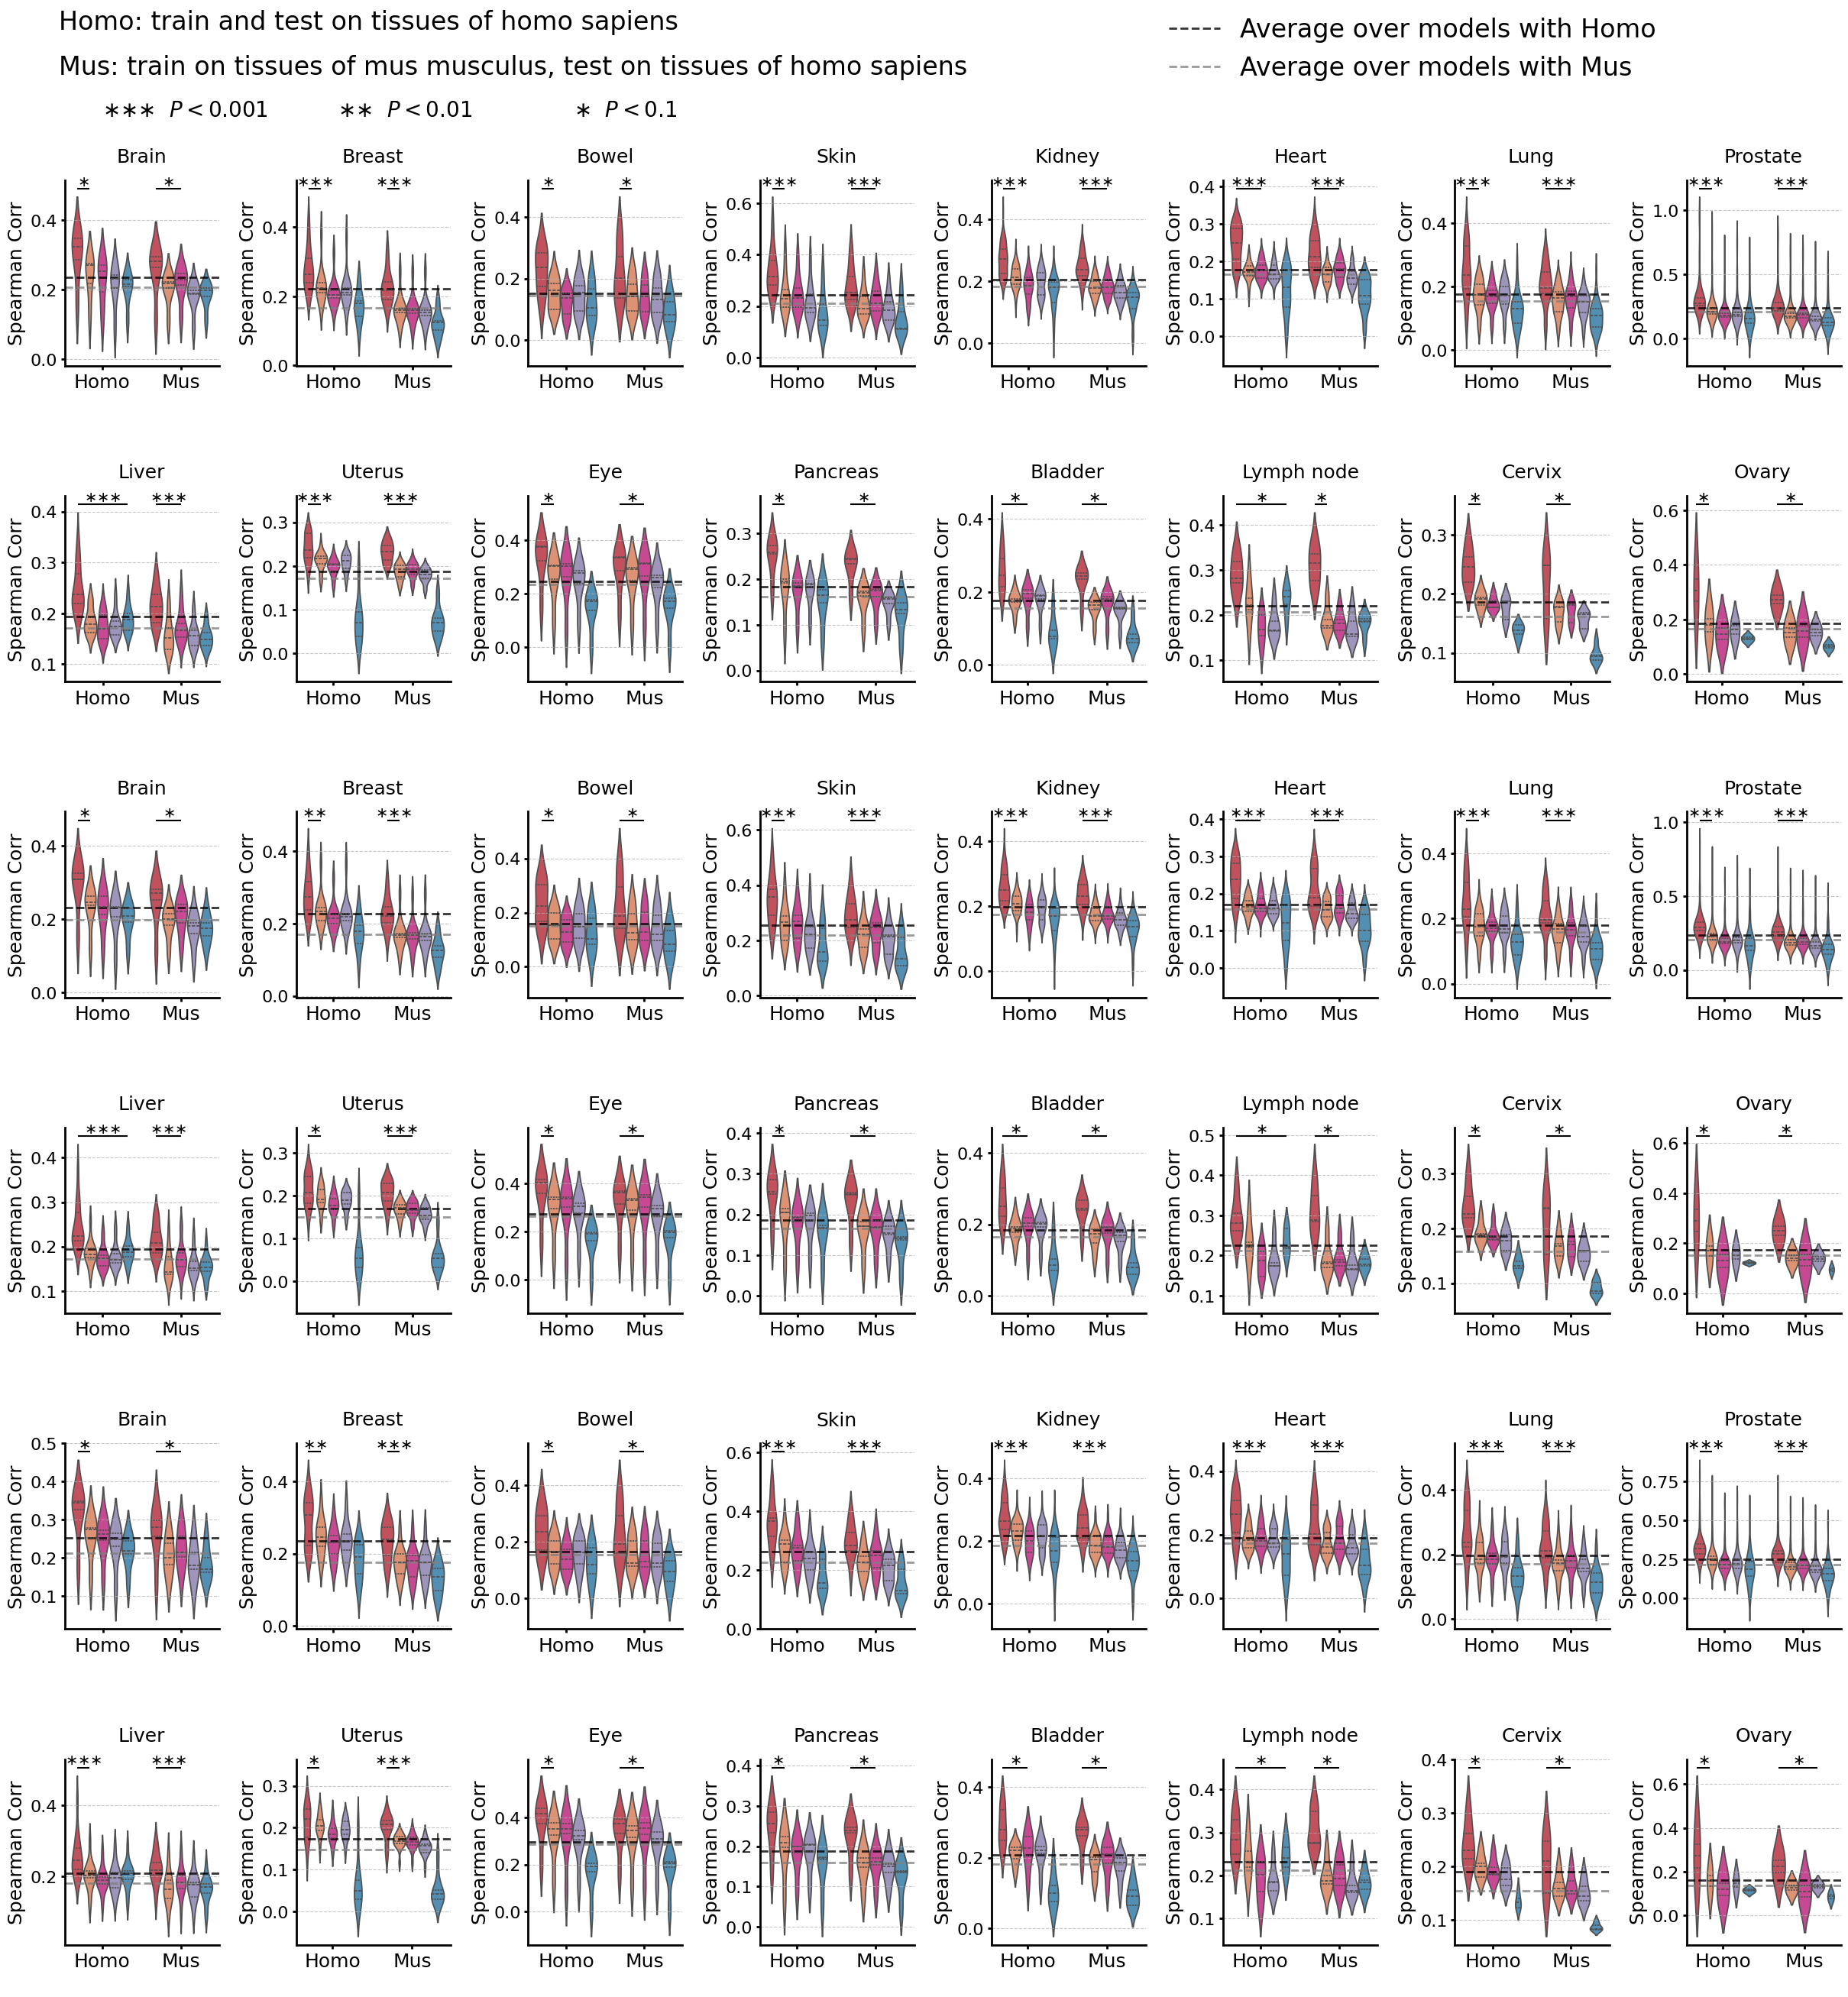

In [5]:
from scipy.stats import wilcoxon

organs = ['Brain', 'Breast', 'Bowel', 'Skin', 'Kidney', 'Heart', 'Lung', 'Prostate', 'Liver', 'Uterus', 'Eye', 
          'Pancreas', 'Bladder', 'Lymph node', 'Cervix', 'Ovary']

domain_2_species_train = {'top5organ': 'Homo sapiens', 'mouse2human': 'Mus musculus'}
result_df['species_train'] = result_df['domain'].map(domain_2_species_train)
result_df_plot = result_df[result_df['species']=='Homo sapiens']
# result_df_plot = result_df_plot[result_df_plot['tech']=='Visium']

fig, axes = plt.subplots(6, 8, figsize=(30, 30), gridspec_kw={'hspace': 0.7, 'wspace': 0.5})
axes = axes.flatten()
handles = []

gene_tops = [4000, 2000, 1000]

for i in range(len(gene_tops)):
    score_key = f'Spearman of top {gene_tops[i]} genes'
    axes_i = axes[i*16:i*16+16]
    for i, organ in enumerate(organs):
        result_df_o = result_df_plot[result_df_plot['organ']==organ]
        ax = axes_i[i]
    
        mean_h = result_df_o[result_df_o['species_train']=='Homo sapiens'][score_key].mean()
        l1 = ax.axhline(y=mean_h, color='black', linestyle='--', linewidth=2, alpha=0.8, label='Average over models with Homo protocol')
        mean_m = result_df_o[result_df_o['species_train']=='Mus musculus'][score_key].mean()
        l2 = ax.axhline(y=mean_m, color='gray', linestyle='--', linewidth=2, alpha=0.8, label='Average over models with Mus protocol')
        if i == 2:
            handles += [l1, l2]
        sns.violinplot(x='species_train', y=score_key, hue='method', data=result_df_o, inner="quart", palette=model_color, ax=ax, 
                       order=['Homo sapiens', 'Mus musculus'], hue_order=model_names)
        # ax.set_title(f'{organ}', fontsize=20)
        # ax.set_ylim(0, 0.5)  # Adjust y-axis if necessary
        ax.set_xlabel(' ', fontsize=14)
        ax.set_ylabel(f'Spearman Corr', fontsize=18)
        ax.tick_params(axis='x', labelsize=18, width=2)
        ax.tick_params(axis='y', labelsize=16, width=2)
        ax.set_xticklabels(['Homo', 'Mus']) 
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.get_legend().remove()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
    
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()   
        ax.text(xlim[0] + (xlim[1] - xlim[0]) * 0.5, ylim[0] + (ylim[1] - ylim[0]) * 1.15, f'{organ}', horizontalalignment='center', fontsize=18)
        # ax.text(xlim[0] + (xlim[1] - xlim[0]) * 0.25, ylim[0] + (ylim[1] - ylim[0]) * 0.95, significance_symbol[significance_label1[i]], horizontalalignment='center', fontsize=15)
        # ax.text(xlim[0] + (xlim[1] - xlim[0]) * 0.75, ylim[0] + (ylim[1] - ylim[0]) * 0.95, significance_symbol[significance_label2[i]], horizontalalignment='center', fontsize=15)
    
        result_df_o_homo = result_df_o[result_df_o['species_train']=='Homo sapiens']
        p_values, baselines = [], []
        for m in model_names:
            score_m = result_df_o_homo[result_df_o_homo['method']==m][score_key].to_numpy()
            if m == 'Ours':
                score_m_ours = score_m
            else:
                _, p_value = wilcoxon(score_m_ours, score_m)
                p_values += [p_value]
                baselines += [np.mean(score_m)]
        x_ends = [-0.16, 0, 0.16, 0.32]
        x_start, x_end, y_pos = -0.32, x_ends[np.argmax(baselines)], ylim[0] + (ylim[1] - ylim[0]) * 1.0
        text = r'$\ast$$\ast$$\ast$' if p_values[np.argmax(baselines)] < 0.001 else r'$\ast$$\ast$' if p_values[np.argmax(baselines)] < 0.01 else r'$\ast$'
        ax.hlines(y=y_pos, xmin=x_start, xmax=x_end, colors='black', linestyles='-')
        ax.text((x_start + x_end) / 2, y_pos, f'{text}', ha='center', va='bottom', color='black', fontsize=14)
    
        result_df_o_mus = result_df_o[result_df_o['species_train']=='Mus musculus']
        p_values, baselines = [], []
        for m in model_names:
            score_m = result_df_o_mus[result_df_o_mus['method']==m][score_key].to_numpy()
            if m == 'Ours':
                score_m_ours = score_m
            else:
                _, p_value = wilcoxon(score_m_ours, score_m)
                p_values += [p_value]
                baselines += [np.mean(score_m)]
        x_ends = [0.84, 1.0, 1.16, 1.84]
        x_start, x_end, y_pos = 0.68, x_ends[np.argmax(baselines)], ylim[0] + (ylim[1] - ylim[0]) * 1.0
        text = r'$\ast$$\ast$$\ast$' if p_values[np.argmax(baselines)] < 0.001 else r'$\ast$$\ast$' if p_values[np.argmax(baselines)] < 0.01 else r'$\ast$'
        ax.hlines(y=y_pos, xmin=x_start, xmax=x_end, colors='black', linestyles='-')
        ax.text((x_start + x_end) / 2, y_pos, f'{text}', ha='center', va='bottom', color='black', fontsize=14)
    
        if i in [3, 15]:
            ax.set_yticks([0., 0.2, 0.4, 0.6]) 
        if i in [2, 10]:
            ax.set_yticks([0., 0.2, 0.4]) 

labels = ['Average over models with Homo', 'Average over models with Mus']
axes[2].legend(handles, labels, loc='upper left', fontsize=24, ncols=1, bbox_to_anchor=(4, 2), frameon=False)
axes[0].text(-0.55, 0.95, r'Homo: train and test on tissues of homo sapiens', fontsize=24)
axes[0].text(-0.55, 0.82, r'Mus: train on tissues of mus musculus, test on tissues of homo sapiens', fontsize=24)

axes[0].text(0, 0.7, r'$\ast$$\ast$$\ast$  $P<0.001$', fontsize=20)
axes[0].text(3, 0.7, r'$\ast$$\ast$  $P<0.01$', fontsize=20)
axes[0].text(6, 0.7, r'$\ast$  $P<0.1$', fontsize=20)

plt.tight_layout()
plt.savefig('../../figure/pred_visium_species.pdf', format="pdf")
plt.show()



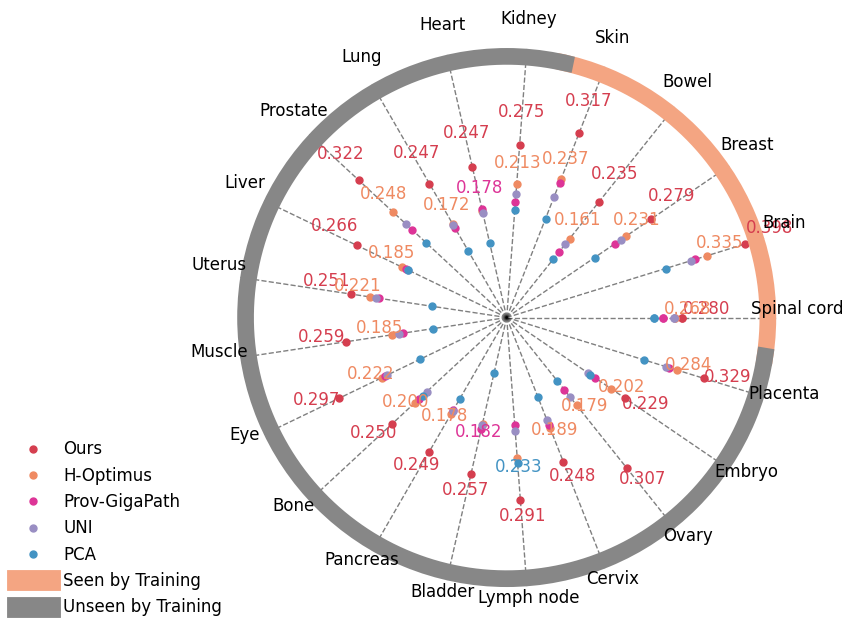

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

metric, gene_top = 'Spearman', 4000
score_key = f'{metric} of top {gene_top} genes'

organs = ['Spinal cord', 'Brain', 'Breast', 'Bowel', 'Skin', 'Kidney', 'Heart', 'Lung', 'Prostate', 'Liver', 'Uterus', 'Muscle', 'Eye', 'Bone', 
          'Pancreas', 'Bladder', 'Lymph node', 'Cervix', 'Ovary', 'Embryo', 'Placenta']

significance_symbol = [r'$\ast$$\ast$$\ast$', r'$\ast$$\ast$', r'$\ast$', ' ']

result_df_plot = result_df[result_df['domain']=='top5organ']
scores = []
for organ in organs:
    result_df_plot_o = result_df_plot[result_df_plot['organ']==organ]
    scores_o = result_df_plot_o[[f'{score_key}', 'method']].groupby(['method']).mean()
    scores += [[scores_o.loc[f'{m}'].values[0] for m in model_names]]
scores = np.array(scores).T
angles = np.linspace(0, 2 * np.pi, len(organs), endpoint=False)

angles = np.append(angles, angles[0])
scores = np.hstack((scores, scores[:, 0][:, None]))

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': 'polar'})

for i, model in enumerate(model_names):
    ax.plot(angles, scores[i], label=model, marker='o', color=model_color[i], linewidth=0., markersize=5)

for j in range(len(organs)):
    angle_rad = angles[j]
    score = scores[0, j]
    ax.annotate(f"{score:.3f}",  # Format score to 2 decimal places
                xy=(angle_rad, score), 
                xytext=(angle_rad, score + 0.04),  # Offset text slightly
                fontsize=12, ha='center', va='bottom', color=model_color[0])

for j in range(len(organs)):
    angle_rad = angles[j]
    idx = np.argmax(scores[1:, j])
    score = scores[1:, j][idx]
    ax.annotate(f"{score:.3f}",  # Format score to 2 decimal places
                xy=(angle_rad, score), 
                xytext=(angle_rad, score + 0.02),  # Offset text slightly
                fontsize=12, ha='center', va='bottom', color=model_color[idx+1])

xlim = ax.get_xlim()
ylim = ax.get_ylim()
for j in range(len(organs)):
    angle_rad = angles[j]
    ax.annotate(f"{organs[j]}",  # Format score to 2 decimal places
                xy=(angle_rad, ylim[1]), 
                xytext=(angle_rad, ylim[1] + 0.05),  # Offset text slightly
                fontsize=12, ha='center', va='bottom', horizontalalignment='center', verticalalignment='center')

angles1 = np.linspace(angles[0]- np.pi / 22, angles[4]+ np.pi / 22, 1000)
ax.plot(angles1, np.ones(angles1.shape[0])*0.42, label='Seen by Training', marker=' ', color='#f4a582', linewidth=15)
angles2 = np.linspace(angles[5]- np.pi / 22, angles[-2]+ np.pi / 22, 2000)
ax.plot(angles2, np.ones(angles2.shape[0])*0.42, label='Unseen by Training', marker=' ', color='#878787', linewidth=15)

# ax.text(0.5*np.pi, 0.6, 'Gene Expression Prediction (Spearman Corr.)', ha='center', va='bottom', color='black', fontsize=14)
ax.set_ylim(0., 0.43)
ax.set_yticklabels([])
ax.legend(loc="upper right", fontsize=12, ncols=1, bbox_to_anchor=(0., 0.3), frameon=False)
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
ax.spines['polar'].set_visible(False)
ax.yaxis.grid(False)
ax.set_xticks(angles[:-1])  # Align radial grid with case labels
ax.xaxis.grid(True, linestyle='dashed', linewidth=1, alpha=0.5, color="black")  # Dashed radial grid

plt.savefig('../../figure/pred_visium_organ_polar.pdf')
plt.show()

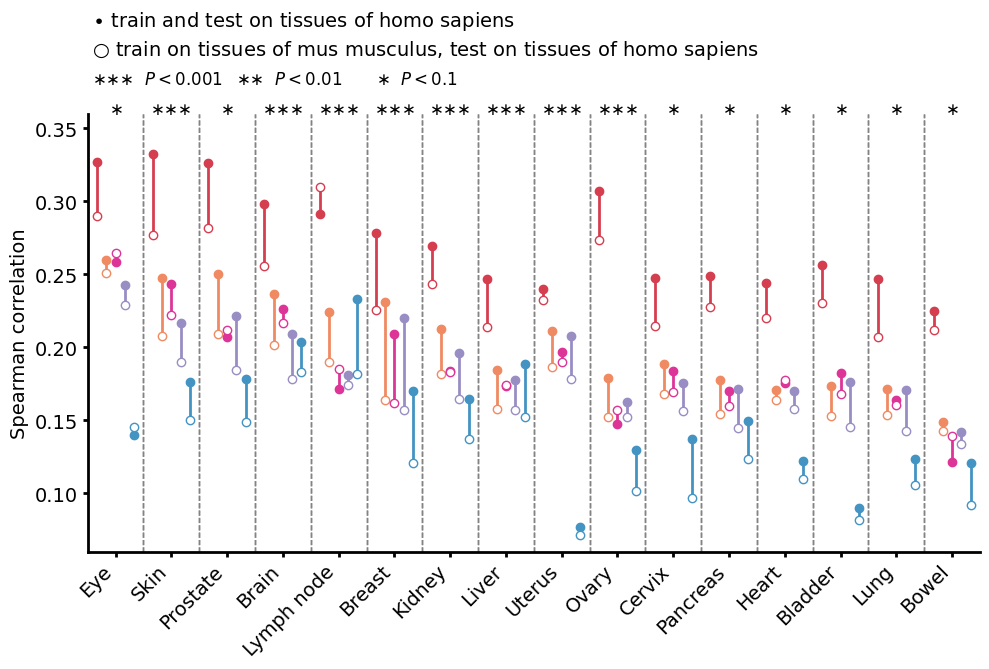

In [7]:
from scipy.interpolate import make_interp_spline

organs = ['Brain', 'Breast', 'Bowel', 'Skin', 'Kidney', 'Heart', 'Lung', 'Prostate', 'Liver', 'Uterus', 'Eye', 
          'Pancreas', 'Bladder', 'Lymph node', 'Cervix', 'Ovary']
significance_label = [2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2 ,2, 2, 2]

domain_2_species_train = {'top5organ': 'Homo sapiens', 'mouse2human': 'Mus musculus'}
result_df['species_train'] = result_df['domain'].map(domain_2_species_train)
result_df_plot = result_df[result_df['species']=='Homo sapiens']
# result_df_plot = result_df_plot[result_df_plot['tech']=='Visium']

fig, ax = plt.subplots(figsize=(10, 7))

metric, gene_top = 'Spearman', 4000
score_key = f'{metric} of top {gene_top} genes'

scores_rank = []
for i, organ in enumerate(organs):
    result_df_o = result_df_plot[result_df_plot['organ']==organ]
    # result_df_o = result_df_o[result_df_o['method']=='Ours']
    mean_score_m_homo = result_df_o[result_df_o['species_train']=='Homo sapiens'][score_key].to_numpy().mean()
    mean_score_m_mus = result_df_o[result_df_o['species_train']=='Mus musculus'][score_key].to_numpy().mean()
    scores_rank += [mean_score_m_homo + mean_score_m_mus]
scores_rank = np.array(scores_rank)
rank_idx = np.argsort(scores_rank)[::-1]
organs_rank = [organs[i] for i in rank_idx]
significance_label_rank = [significance_label[i] for i in rank_idx]

for k, m in enumerate(model_names):
    result_df_m = result_df_plot[result_df_plot['method']==m]
    result_df_m_homo = result_df_m[result_df_m['species_train']=='Homo sapiens']
    result_df_m_mus = result_df_m[result_df_m['species_train']=='Mus musculus']
    score_homo, score_mus = [], []
    x = np.arange(0, len(organs_rank))
    
    for i, organ in enumerate(organs_rank):
        score_homo += [result_df_m_homo[result_df_m_homo['organ']==organ][score_key].to_numpy().mean()]
        score_mus += [result_df_m_mus[result_df_m_mus['organ']==organ][score_key].to_numpy().mean()]

    # y_min = [min(h, m) for h, m in zip(score_homo, score_mus)]
    # y_max = [max(h, m) for h, m in zip(score_homo, score_mus)]
    # x_smooth = np.linspace(x.min(), x.max(), 300)
    # spline_y1 = make_interp_spline(x, y_min, k=3)(x_smooth)
    # spline_y2 = make_interp_spline(x, y_max, k=3)(x_smooth)
    # plt.plot(x_smooth, spline_y1, color=model_color[k], linewidth=2)
    # plt.plot(x_smooth, spline_y2, color=model_color[k], linewidth=2)
    # ax.fill_between(x_smooth, spline_y1, spline_y2, color=model_color[k], alpha=0.1, label='between')
    
    # ax.plot(x, score_homo, label=m, marker='o', color=model_color[k], linewidth=0., markersize=6)
    # ax.plot(x, score_mus, label=m, marker='o', markerfacecolor='#ffffff', color=model_color[k], linewidth=0., markersize=6)
    
    for i in range(len(x)):
        ax.vlines(x=x[i]*6+k, ymin=min(score_homo[i], score_mus[i])+0.001, ymax=max(score_homo[i], score_mus[i])-0.001, colors=model_color[k], linewidth=2)       
        ax.plot(x[i]*6+k, score_homo[i], label=m, marker='o', color=model_color[k], linewidth=0., markersize=6)
        ax.plot(x[i]*6+k, score_mus[i], label=m, marker='o', markerfacecolor='#ffffff', color=model_color[k], linewidth=0., markersize=6)
        if i<15:
            ax.vlines(x=x[i]*6+5, ymin=0.06, ymax=0.36, alpha=0.5, color="gray", linewidth=1, linestyle='dashed')       

significance_symbol = [r'$\ast$$\ast$$\ast$', r'$\ast$$\ast$', r'$\ast$', ' ']
for i, sig_label in enumerate(significance_label):
    ax.text(x[i]*6+2, 0.36, significance_symbol[sig_label], horizontalalignment='center', fontsize=12)


ax.set_xticks([j*6+2 for j in range(len(organs))]) 
ax.set_xticklabels(organs_rank, rotation=45, ha='right')
ax.set_ylabel(f'{metric} correlation', fontsize=14)
ax.tick_params(axis='x', labelsize=14, width=2)
ax.tick_params(axis='y', labelsize=14, width=2)
# ax.grid(axis='y', linestyle='dashed', linewidth=1, alpha=0.5, color="black")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.set_xlim([-1, 95]) 
ax.set_ylim([0.06, 0.36]) 
ax.set_yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]) 

# labels = ['Average over models with Homo', 'Average over models with Mus']
# axes[2].legend(handles, labels, loc='upper left', fontsize=18, ncols=1, bbox_to_anchor=(0.5, 2.1), frameon=False)
ax.text(-0.55, 0.42, r'$\bullet$ train and test on tissues of homo sapiens', fontsize=14)
ax.text(-0.55, 0.4, r'$\bigcirc$ train on tissues of mus musculus, test on tissues of homo sapiens', fontsize=14)

ax.text(-0.55, 0.38, r'$\ast$$\ast$$\ast$  $P<0.001$', fontsize=12)
ax.text(15, 0.38, r'$\ast$$\ast$  $P<0.01$', fontsize=12)
ax.text(30, 0.38, r'$\ast$  $P<0.1$', fontsize=12)

# axes[0].text(5.6, 0.7, r'$\ast$$\ast$$\ast$  $P<0.001$', fontsize=16)
# axes[0].text(6.9, 0.7, r'$\ast$$\ast$  $P<0.01$', fontsize=16)
# axes[0].text(8, 0.7, r'$\ast$  $P<0.1$', fontsize=16)

plt.tight_layout()
plt.savefig('../../figure/pred_visium_species_line.pdf', format="pdf")
plt.show()

In [10]:
# significance test
from scipy.stats import wilcoxon

organs = ['Spinal cord', 'Brain', 'Breast', 'Bowel', 'Skin', 'Kidney', 'Heart', 'Lung', 'Prostate', 'Liver', 'Uterus', 'Muscle', 'Eye', 'Bone', 
          'Pancreas', 'Bladder', 'Lymph node', 'Cervix', 'Ovary', 'Embryo', 'Placenta']
result_df1 = result_df[result_df['domain']=='top5organ']
# result_df1 = result_df1[result_df1['species']=='Homo sapiens']
# result_df1 = result_df1[result_df1['tech']=='Visium']

metric, gene_top = 'Spearman', 2000
score_key = f'{metric} of top {gene_top} genes'

for i, organ in enumerate(organs):
    result_df_o = result_df1[result_df1['organ']==organ]
    score_ours = result_df_o[result_df_o['method']=='Ours'][score_key].tolist()
    score_comp_best = result_df_o[result_df_o['method']=='H-Optimus'][score_key].tolist()
    stat, p_value = wilcoxon(score_ours, score_comp_best)
    print(i, len(score_ours), p_value)


# organs = ['Brain', 'Breast', 'Bowel', 'Skin', 'Kidney', 'Heart', 'Lung', 'Prostate', 'Liver', 'Uterus', 'Eye', 
#           'Pancreas', 'Bladder', 'Lymph node', 'Cervix', 'Ovary']
# result_df1 = result_df[result_df['species']=='Homo sapiens']
# result_df2 = result_df1[result_df1['species_train']=='Homo sapiens'] # Homo sapiens or Mus musculus
# # result_df1 = result_df1[result_df1['tech']=='Visium']

# metric, gene_top = 'Spearman', 4000
# score_key = f'{metric} of top {gene_top} genes'

# for i, organ in enumerate(organs):
#     result_df_o = result_df2[result_df2['organ']==organ]
#     score_ours = result_df_o[result_df_o['method']=='Ours'][score_key].tolist()
#     score_comp_best = result_df_o[result_df_o['method']=='H-Optimus'][score_key].tolist()
#     stat, p_value = wilcoxon(score_ours, score_comp_best)
#     print(i, len(score_ours), p_value)


# result_df2 = result_df1[result_df1['species_train']=='Mus musculus'] # Homo sapiens or Mus musculus
# # result_df1 = result_df1[result_df1['tech']=='Visium']

# metric, gene_top = 'Spearman', 4000
# score_key = f'{metric} of top {gene_top} genes'

# for i, organ in enumerate(organs):
#     result_df_o = result_df2[result_df2['organ']==organ]
#     score_ours = result_df_o[result_df_o['method']=='Ours'][score_key].tolist()
#     score_comp_best = result_df_o[result_df_o['method']=='H-Optimus'][score_key].tolist()
#     stat, p_value = wilcoxon(score_ours, score_comp_best)
#     print(i, len(score_ours), p_value)

0 36 0.005999622109811753
1 30 5.718320608139038e-07
2 12 0.00146484375
3 10 0.001953125
4 12 0.00048828125
5 68 1.850579100740655e-12
6 65 5.796849950994542e-12
7 38 7.275957614183426e-12
8 49 3.552713678800501e-15
9 35 5.820766091346741e-11
10 23 0.0021359920501708984
11 10 0.001953125
12 10 0.001953125
13 6 0.03125
14 5 0.0625
15 6 0.03125
16 5 0.0625
17 5 0.0625
18 2 0.5
19 2 0.5
20 1 1.0


Index(['Visium', 'Spatial Transcriptomics', 'Xenium', 'Visium HD'], dtype='object', name='tech')


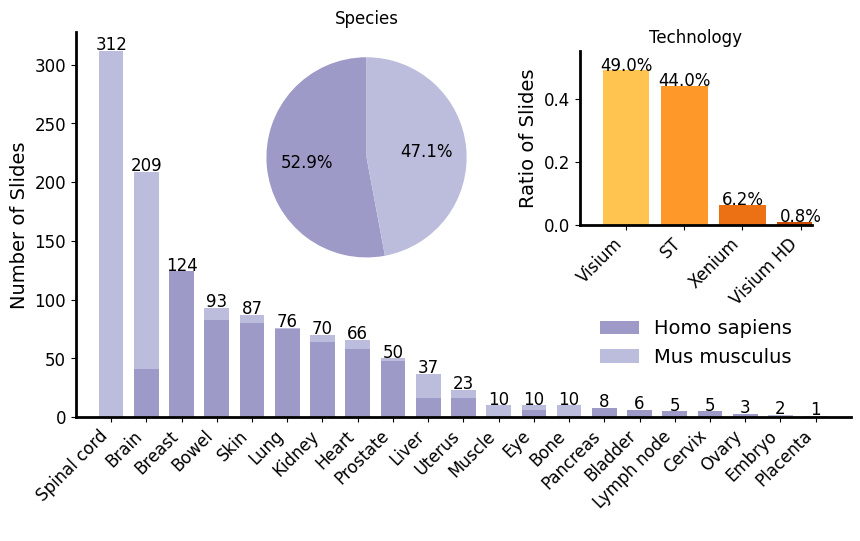

In [86]:
dir_path1 = '/data/wuqitian/hest_data_visium_protein_preprocess'
meta_info1 = pd.read_csv("../../data/meta_info_visium.csv")

dir_path2 = '/data/wuqitian/hest_data_xenium_protein_preprocess'
meta_info2 = pd.read_csv("../../data/meta_info_xenium.csv")

meta_info_lung = pd.DataFrame({'sample': [f'lung_{i}' for i in range(16)], 
                               'organ': ['Lung' for i in range(16)],
                               'species': ['Homo sapiens' for i in range(16)],
                               'tech': ['Xenium' for i in range(16)],
                               'state': ['Diseased' for i in range(16)],
                              })

data_df = pd.merge(meta_info1, meta_info2, how='outer')
data_df = pd.merge(data_df, meta_info_lung, how='outer')

organs = ['Spinal cord', 'Brain', 'Breast', 'Bowel', 'Skin', 'Lung', 'Kidney', 'Heart', 'Prostate', 'Liver', 'Uterus', 'Muscle', 'Eye', 'Bone', 
          'Pancreas', 'Bladder', 'Lymph node', 'Cervix', 'Ovary', 'Embryo', 'Placenta']

data_df = data_df[data_df['organ'].isin(organs)]

df_counts = data_df.groupby(['organ', 'species']).size().reset_index(name='count')
df_counts['organ'] = pd.Categorical(df_counts['organ'], categories=organs, ordered=True)

df_pivot = df_counts.pivot(index='organ', columns='species', values='count').fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))

df_pivot.plot(kind='bar', stacked=True, color=['#9e9ac8', '#bcbddc'], width=0.7, ax=ax)

ax.set_xlabel(' ')
ax.set_ylabel('Number of Slides', fontsize=14)
ax.legend(loc='upper center', fontsize=14, ncols=1, bbox_to_anchor=(0.8, 0.3), frameon=False)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticklabels(organs, rotation=45, fontsize=12)
ax.set_xticklabels(organs, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_xlim(-1, len(organs))

organ_counts = data_df['organ'].value_counts()
for i, organ in enumerate(organs):
    total_samples = organ_counts.loc[organ]
    ax.text(i, total_samples+5, str(int(total_samples)), va='center', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')


species_counts = data_df['species'].value_counts()
ax_inset = ax.inset_axes([0.05, 0.35, 0.65, 0.65])  # Adjust position and size
ax_inset.pie(species_counts, autopct='%1.1f%%', startangle=90, colors=['#9e9ac8', '#bcbddc'], textprops={'fontsize': 12})
ax_inset.set_title('Species')

tech_counts = data_df['tech'].value_counts()
tech_ratio = tech_counts / tech_counts.sum()
ax_inset_bar = ax.inset_axes([0.65, 0.5, 0.3, 0.45])  # Adjust position

tech_colors = ['#fec44f', '#fe9929', '#ec7014', '#cc4c02']  # Assign unique colors
bars = ax_inset_bar.bar(np.arange(4), tech_ratio.values, width=0.8, color=tech_colors)
print(tech_ratio.index)
ax_inset_bar.set_ylabel('Ratio of Slides', fontsize=14)
ax_inset_bar.set_title('Technology')
ax_inset_bar.tick_params(axis='y', labelsize=12)
ax_inset_bar.set_xticks(range(len(tech_ratio.index)))  # Ensure proper tick locations
ax_inset_bar.set_xticklabels(['Visium', 'ST', 'Xenium', 'Visium HD'], rotation=45, ha='right', fontsize=12)
ax_inset_bar.spines['top'].set_visible(False)
ax_inset_bar.spines['right'].set_visible(False)
ax_inset_bar.spines['bottom'].set_linewidth(2)
ax_inset_bar.spines['left'].set_linewidth(2)
ax_inset_bar.set_xlim(-0.8, len(bars)-0.8)
ax_inset_bar.set_ylim(0, 0.55)

# Add text above each bar showing the ratio
for bar in bars:
    height = bar.get_height()
    ax_inset_bar.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1%}', 
                      ha='center', fontsize=12, color='black')

plt.savefig('../../figure/pred_visium_data_info.pdf')
plt.show()

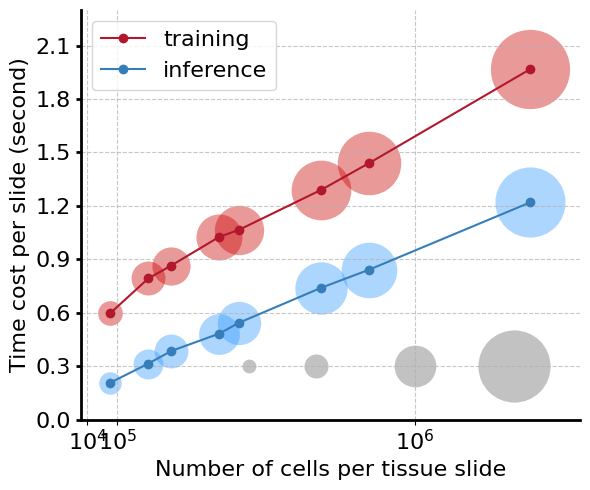

In [13]:

sample_sizes = [136189, 1349529, 863281, 64740, 87846, 239246, 26355, 156435]
train_times = [0.2941, 1.2197, 0.8424, 0.2380, 0.2616, 0.3801, 0.2022, 0.3147]
train_mems = [2878, 25498, 16046, 1548, 1984, 4738, 878, 3244]
test_times = [0.7085, 1.9679, 1.4414, 0.6307, 0.6549, 0.7968, 0.5657, 0.7220]
test_mems = [3666, 32514, 20934, 1988, 2524, 6158, 1056, 4206]

sample_sizes = np.array(sample_sizes)
train_times, train_mems = np.array(train_times), np.array(train_mems) / 1000
test_times, test_mems = np.array(test_times), np.array(test_mems) / 1000

idx = np.argsort(sample_sizes)
sample_sizes, train_times, train_mems, test_times, test_mems = \
    sample_sizes[idx], train_times[idx], train_mems[idx], test_times[idx], test_mems[idx]

sample_sizes[:-2], train_times[:-2], train_mems[:-2], test_times[:-2], test_mems[:-2] = \
    sample_sizes[:-2] * 3, (train_times[:-2]-0.2) * 3+0.2, train_mems[:-2] * 3, (test_times[:-2]-0.55) * 3+0.55, test_mems[:-2] * 3

train_marker_size = [m*100 for m in train_mems]
test_marker_size = [m*100 for m in test_mems]

fig, ax = plt.subplots(figsize=(6, 5))
# ax.set_yscale('log')

ax.plot(sample_sizes, test_times, marker='o', color='#b2182b', markerfacecolor='#b2182b', markersize=6, linestyle='solid', label='training')
for x, t, m in zip(sample_sizes, test_times, test_marker_size):
    ax.scatter(x, t, s=m, marker='o', facecolors='#CC0000', linewidths=0., alpha=0.4)
ax.plot(sample_sizes, train_times, marker='o', color='#377eb8', markerfacecolor='#377eb8', markersize=6, linestyle='solid', label='inference')
for x, t, m in zip(sample_sizes, train_times, train_marker_size):
    ax.scatter(x, t, s=m, marker='o', facecolors='#3399FF', linewidths=0., alpha=0.4)


ax.set_xlabel('Number of cells per tissue slide', fontsize=16)
ax.set_ylabel('Time cost per slide (second)', fontsize=16, color='black')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelcolor='black', labelsize=16, width=2)
ax.set_xlim([-10000, 1500000])
ax.set_xticks([10000, 100000, 1000000]) 
ax.set_xticklabels([r'$10^4$', r'$10^5$', r'$10^6$'], fontsize=16)
ax.set_ylim([-0., 2.3])
ax.set_yticks([0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1]) 

# ax2 = ax.twinx()  
# ax2.plot(sample_sizes, train_mems, marker='o', color='#377eb8', markerfacecolor='#ffffff', markersize=6, linestyle='solid', label='train memory')
# ax2.plot(sample_sizes, test_mems, marker='s', color='#377eb8', markerfacecolor='#ffffff', markersize=6, linestyle='solid', label='inference memory')
# ax2.set_ylabel('Memory cost (GB)', fontsize=16, color='#377eb8')  # we already handled the x-label with ax1
# ax2.tick_params(axis='y', labelcolor='#377eb8', labelsize=16, width=2)
# ax2.spines['right'].set_linewidth(2)
# ax2.spines['top'].set_linewidth(2)
# ax2.set_ylim([0, 35])

ax.legend(loc="upper left", fontsize=16, frameon=True)
# ax2.legend(loc="upper right", fontsize=16, frameon=True)

ax.scatter(500000, 0.3, s=100, marker='o', facecolors='#878787', linewidths=0., alpha=0.5)
ax.scatter(700000, 0.3, s=300, marker='o', facecolors='#878787', linewidths=0., alpha=0.5)
ax.scatter(1000000, 0.3, s=900, marker='o', facecolors='#878787', linewidths=0., alpha=0.5)
ax.scatter(1300000, 0.3, s=2700, marker='o', facecolors='#878787', linewidths=0., alpha=0.5)

ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../../figure/pred_visium_scalability.pdf')
plt.show()
